In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 40
pd.options.display.max_columns = 40
!ls data/kaggle_data

most-recent-event.csv
task-dummy.csv
ufc-master.csv
upcoming-event.csv


In [2]:
import math
import torch
import gpytorch

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
gpytorch.__version__

'1.2.1'

In [4]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

In [5]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

In [6]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50
print(smoke_test)

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

False
Iter 1/50 - Loss: 0.950   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.919   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.886   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.848   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.806   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.758   lengthscale: 0.475   noise: 0.474
Iter 7/50 - Loss: 0.707   lengthscale: 0.439   noise: 0.437
Iter 8/50 - Loss: 0.655   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.606   lengthscale: 0.372   noise: 0.369
Iter 10/50 - Loss: 0.562   lengthscale: 0.342   noise: 0.339
Iter 11/50 - Loss: 0.522   lengthscale: 0.315   noise: 0.310
Iter 12/50 - Loss: 0.486   lengthscale: 0.292   noise: 0.284
Iter 13/50 - Loss: 0.452   lengthscale: 0.272   noise: 0.259
Iter 14/50 - Loss: 0.419   lengthscale: 0.256   noise: 0.237
Iter 15/50 - Loss: 0.387   lengthscale: 0.243   noise: 0.216
Iter 16/50 - Loss: 0.356   lengthscale: 0.232   noise: 0.196
Iter 17/50 - Loss: 0.325   

C:\Users\John\anaconda3\envs\sports\lib\site-packages\gpytorch\utils\cholesky.py:27: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).transpose(-2, -1).conj().
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:1285.)
  L = torch.cholesky(A, upper=upper, out=out)


In [7]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    observed_pred = likelihood(model(test_x))

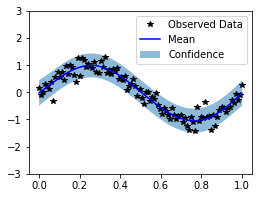

In [8]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

# Custom kernel

In [9]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)

# Wrap training, prediction and plotting from the ExactGP-Tutorial into a function,
# so that we do not have to repeat the code later on
def train(model, likelihood, training_iter=training_iter):
    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()


def predict(model, likelihood, test_x = torch.linspace(0, 1, 51)):
    model.eval()
    likelihood.eval()
    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        # Test points are regularly spaced along [0,1]
        return likelihood(model(test_x))

def plot(observed_pred, test_x=torch.linspace(0, 1, 51)):
    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(1, 1, figsize=(4, 3))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
        ax.set_ylim([-3, 3])
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [10]:
class FirstSincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # calculate the distance between inputs
        diff = self.covar_dist(x1, x2, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

In [11]:
# Use the simplest form of GP model, exact inference
class FirstGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = FirstSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

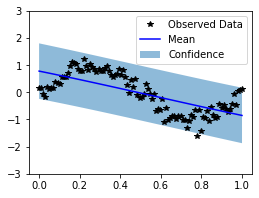

In [12]:
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = FirstGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

In [13]:
# import positivity constraint
from gpytorch.constraints import Positive

class SincKernel(gpytorch.kernels.Kernel):
    # the sinc kernel is stationary
    is_stationary = True

    # We will register the parameter when initializing the kernel
    def __init__(self, length_prior=None, length_constraint=None, **kwargs):
        super().__init__(**kwargs)

        # register the raw parameter
        self.register_parameter(
            name='raw_length', parameter=torch.nn.Parameter(torch.zeros(*self.batch_shape, 1, 1))
        )

        # set the parameter constraint to be positive, when nothing is specified
        if length_constraint is None:
            length_constraint = Positive()

        # register the constraint
        self.register_constraint("raw_length", length_constraint)

        # set the parameter prior, see
        # https://docs.gpytorch.ai/en/latest/module.html#gpytorch.Module.register_prior
        if length_prior is not None:
            self.register_prior(
                "length_prior",
                length_prior,
                lambda m: m.length,
                lambda m, v : m._set_length(v),
            )

    # now set up the 'actual' paramter
    @property
    def length(self):
        # when accessing the parameter, apply the constraint transform
        return self.raw_length_constraint.transform(self.raw_length)

    @length.setter
    def length(self, value):
        return self._set_length(value)

    def _set_length(self, value):
        if not torch.is_tensor(value):
            value = torch.as_tensor(value).to(self.raw_length)
        # when setting the paramater, transform the actual value to a raw one by applying the inverse transform
        self.initialize(raw_length=self.raw_length_constraint.inverse_transform(value))

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.length)
        x2_ = x2.div(self.length)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

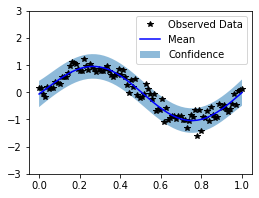

In [14]:
# Use the simplest form of GP model, exact inference
class SincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
model = SincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

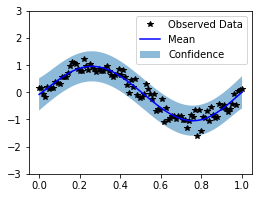

In [15]:
class SimpleSincKernel(gpytorch.kernels.Kernel):
    has_lengthscale = True

    # this is the kernel function
    def forward(self, x1, x2, **params):
        # apply lengthscale
        x1_ = x1.div(self.lengthscale)
        x2_ = x2.div(self.lengthscale)
        # calculate the distance between inputs
        diff = self.covar_dist(x1_, x2_, **params)
        # prevent divide by 0 errors
        diff.where(diff == 0, torch.as_tensor(1e-20))
        # return sinc(diff) = sin(diff) / diff
        return torch.sin(diff).div(diff)

# Use the simplest form of GP model, exact inference
class SimpleSincGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = SimpleSincKernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize the new model
model = SimpleSincGPModel(train_x, train_y, likelihood)

# set to training mode and train
model.train()
likelihood.train()
train(model, likelihood)

# Get into evaluation (predictive posterior) mode and predict
model.eval()
likelihood.eval()
observed_pred = predict(model, likelihood)
# plot results
plot(observed_pred)

# UFC fights

In [16]:
df = pd.read_csv("data/kaggle_data/ufc-master.csv")
df.head()

,R_fighter,B_fighter,R_odds,B_odds,R_ev,B_ev,date,location,country,Winner,title_bout,weight_class,gender,no_of_rounds,B_current_lose_streak,B_current_win_streak,B_draw,B_avg_SIG_STR_landed,B_avg_SIG_STR_pct,B_avg_SUB_ATT,...,B_Light Heavyweight_rank,B_Middleweight_rank,B_Welterweight_rank,B_Lightweight_rank,B_Featherweight_rank,B_Bantamweight_rank,B_Flyweight_rank,B_Pound-for-Pound_rank,better_rank,finish,finish_details,finish_round,finish_round_time,total_fight_time_secs,r_dec_odds,b_dec_odds,r_sub_odds,b_sub_odds,r_ko_odds,b_ko_odds
0,Thiago Santos,Johnny Walker,-150.0,130,66.666667,130.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Light Heavyweight,MALE,5,0,1,0,3.42,0.59,0.7,...,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Red,U-DEC,NaN,5.0,5:00,1500.0,800.0,900.0,2000.0,1600.0,-110.0,175.0
1,Alex Oliveira,Niko Price,170.0,-200,170.000000,50.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Welterweight,MALE,3,2,0,0,5.16,0.42,0.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,U-DEC,NaN,3.0,5:00,900.0,450.0,350.0,700.0,1100.0,550.0,120.0
2,Misha Cirkunov,Krzysztof Jotko,110.0,-130,110.000000,76.923077,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Middleweight,MALE,3,1,0,0,2.92,0.41,0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,S-DEC,NaN,3.0,5:00,900.0,550.0,275.0,275.0,1400.0,600.0,185.0
3,Alexander Hernandez,Mike Breeden,-675.0,475,14.814815,475.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Red,False,Lightweight,MALE,3,1,0,0,4.04,0.34,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,KO/TKO,Punch,1.0,1:20,80.0,175.0,900.0,500.0,3500.0,110.0,1100.0
4,Joe Solecki,Jared Gordon,-135.0,115,74.074074,115.000000,2021-10-02,"Las Vegas, Nevada, USA",USA,Blue,False,Lightweight,MALE,3,0,2,0,5.22,0.56,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,neither,S-DEC,NaN,3.0,5:00,900.0,165.0,200.0,400.0,1200.0,900.0,600.0


In [17]:
def get_implied_opener_prob(x):
    if x < 0: # favorite
        x *= 1
        return x / (x + 100)
    return 100 / (x + 100)

p_R = df["R_odds"].apply(get_implied_opener_prob)
p_B = df["B_odds"].apply(get_implied_opener_prob)
p_R_norm = p_R / (p_R + p_B)
df["p_R_norm"] = p_R_norm

y_true = df["Winner"] == "Red"
y_pred = df["p_R_norm"]
ignore_inds = y_true.isnull() | y_pred.isnull() | (df["finish"].isin(["DQ", "Overturned", "M-DEC"]))
y_true = y_true.loc[~ignore_inds]
y_pred = y_pred.loc[~ignore_inds]
ignore_inds = df["Winner"].isnull() | df["p_R_norm"].isnull() | (df["finish"].isin(["DQ", "Overturned", "M-DEC"]))

temp_df = df.loc[~ignore_inds].copy()
temp_df["date"] = pd.to_datetime(temp_df["date"])
temp_df["y_true"] = (temp_df["Winner"] == "Red").astype(int)
date_split = temp_df["date"].quantile(0.8) # 80-20 split
train_df = temp_df.query("date <= '{}'".format(date_split))
test_df = temp_df.query("date > '{}'".format(date_split))
print(train_df.shape, test_df.shape)

(3885, 121) (962, 121)


In [18]:
from sklearn.preprocessing import OneHotEncoder

fighter_encoder = OneHotEncoder()
fighters = set()
for temp_df in [train_df, test_df]:
    for col in ["R_fighter", "B_fighter"]:
        fighters = fighters | set(temp_df[col])
fighters = sorted(fighters)
fighter_encoder.fit(np.array(fighters).reshape(-1, 1))

y = (train_df["Winner"] == "Red").astype(int)
fighter_A = fighter_encoder.transform(train_df["R_fighter"].values.reshape(-1, 1)).todense()
fighter_B = fighter_encoder.transform(train_df["B_fighter"].values.reshape(-1, 1)).todense()
n_fighters = len(fighters)

In [19]:
fighter_A.shape

(3885, 1742)

In [20]:
fighter_X = fighter_A - fighter_B 
fighter_X

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [21]:
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process import GaussianProcessClassifier

kernel = DotProduct()
gpc = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(fighter_X, y)
gpc.score(fighter_X, y)

gpc.predict_proba(fighter_X[:2,:])

C:\Users\John\anaconda3\envs\sports\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\John\anaconda3\envs\sports\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\John\anaconda3\envs\sports\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


array([[0.37989281, 0.62010719],
       [0.60054813, 0.39945187]])

In [22]:
# okay awesome, that's about what i expected
test_y = (test_df["Winner"] == "Red").astype(int)
fighter_A = fighter_encoder.transform(test_df["R_fighter"].values.reshape(-1, 1)).todense()
fighter_B = fighter_encoder.transform(test_df["B_fighter"].values.reshape(-1, 1)).todense()
test_X = fighter_A - fighter_B
gpc.score(test_X, test_y)

C:\Users\John\anaconda3\envs\sports\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.5675675675675675

In [23]:
gpc.score(fighter_X, y)

C:\Users\John\anaconda3\envs\sports\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


0.818018018018018

In [24]:
# Use the simplest form of GP model, exact inference
class SimpleEloModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            gpytorch.kernels.LinearKernel(batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
# we let the DirichletClassificationLikelihood compute the targets for us
from gpytorch.likelihoods import DirichletClassificationLikelihood

likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)

ImportError: cannot import name 'DirichletClassificationLikelihood' from 'gpytorch.likelihoods' (C:\Users\John\anaconda3\envs\sports\lib\site-packages\gpytorch\likelihoods\__init__.py)

In [25]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy


class GPClassificationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(
            self, train_x, variational_distribution, learn_inducing_locations=False
        )
        super(GPClassificationModel, self).__init__(variational_strategy)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred


# Initialize model and likelihood
model = GPClassificationModel(train_x)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [28]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 1.343
Iter 2/50 - Loss: 13.237
Iter 3/50 - Loss: 67.082
Iter 4/50 - Loss: 18.996
Iter 5/50 - Loss: 36.213
Iter 6/50 - Loss: 35.738
Iter 7/50 - Loss: 18.970
Iter 8/50 - Loss: 11.996
Iter 9/50 - Loss: 14.184
Iter 10/50 - Loss: 16.863
Iter 11/50 - Loss: 15.215
Iter 12/50 - Loss: 12.214
Iter 13/50 - Loss: 10.751
Iter 14/50 - Loss: 10.305
Iter 15/50 - Loss: 9.916
Iter 16/50 - Loss: 8.445
Iter 17/50 - Loss: 7.729
Iter 18/50 - Loss: 7.277
Iter 19/50 - Loss: 7.469
Iter 20/50 - Loss: 7.304
Iter 21/50 - Loss: 6.939
Iter 22/50 - Loss: 6.458
Iter 23/50 - Loss: 6.077
Iter 24/50 - Loss: 6.089
Iter 25/50 - Loss: 5.916
Iter 26/50 - Loss: 5.940
Iter 27/50 - Loss: 5.890
Iter 28/50 - Loss: 5.937
Iter 29/50 - Loss: 5.935
Iter 30/50 - Loss: 5.876
Iter 31/50 - Loss: 5.731
Iter 32/50 - Loss: 5.628
Iter 33/50 - Loss: 5.581
Iter 34/50 - Loss: 5.506
Iter 35/50 - Loss: 5.426
Iter 36/50 - Loss: 5.281
Iter 37/50 - Loss: 5.130
Iter 38/50 - Loss: 4.967
Iter 39/50 - Loss: 4.807
Iter 40/50 - Loss: 4.

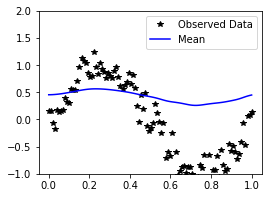

In [39]:
# Go into eval mode
model.eval()
likelihood.eval()

with torch.no_grad():
    # Test x are regularly spaced by 0.01 0,1 inclusive
    test_x = torch.linspace(0, 1, 101)
    # Get classification predictions
    observed_pred = likelihood(model(test_x))

    # Initialize fig and axes for plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Get the predicted labels (probabilites of belonging to the positive class)
    # Transform these probabilities to be 0/1 labels
#     pred_labels = observed_pred.mean.ge(0.5).float()
    pred_labels = observed_pred.mean.float()
    ax.plot(test_x.numpy(), pred_labels.numpy(), 'b')
    ax.set_ylim([-1, 2])
    ax.legend(['Observed Data', 'Mean'])

In [ ]:
assert False

In [ ]:
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

class GPWinModel(object):
    
    def __init__(self, sigma_alpha=1):
        self.sigma_alpha = sigma_alpha
        self.fighter_encoder = OneHotEncoder()
        self.fighters = []
        self.stan_data = None
        self.stan_fit = None
        
    def fit_fighter_encoder(self, train_df, test_df):
        # have to pool fighters in train and test
        # careful about data leakage!
        fighters = set()
        for temp_df in [train_df, test_df]:
            for col in ["R_fighter", "B_fighter"]:
                fighters = fighters | set(temp_df[col])
        fighters = sorted(fighters)
        self.fighter_encoder.fit(np.array(fighters).reshape(-1, 1)) 
    
    def fit_predict(self, train_df, test_df, mcmc=False, mcmc_iter=1000, mcmc_warmup=500):
        self.fit_fighter_encoder(train_df, test_df)
        # get stuff to feed into stan
        n_fighters = len(self.fighter_encoder.categories_[0])
        n_fights = train_df.shape[0]
        # n_regressors
        y = (train_df["Winner"] == "Red").astype(int)
        fighter_A = self.fighter_encoder.transform(train_df["R_fighter"].values.reshape(-1, 1)).todense()
        fighter_B = self.fighter_encoder.transform(train_df["B_fighter"].values.reshape(-1, 1)).todense()
        # X_A, X_B
        fight_date = np.zeros(n_fights) # I'll figure out how to calculate this later
        sigma_alpha = self.sigma_alpha
        # sigma_beta
        n_fights_test = test_df.shape[0]
        fighter_A_test = self.fighter_encoder.transform(test_df["R_fighter"].values.reshape(-1, 1)).todense()
        fighter_B_test = self.fighter_encoder.transform(test_df["B_fighter"].values.reshape(-1, 1)).todense()
        fight_date_test = np.zeros(n_fights_test)
        
        stan_data = {
            "n_fighters": n_fighters,
            "n_fights": n_fights,
            "y": y.values,
            "fighter_A": fighter_A,
            "fighter_B": fighter_B,
            "fight_date": fight_date,
            "sigma_alpha": sigma_alpha,
            "n_fights_test": n_fights_test,
            "fighter_A_test": fighter_A_test,
            "fighter_B_test": fighter_B_test,
            "fight_date_test": fight_date_test,
        }
        self.stan_data = stan_data
        # Train the model and generate samples
        if mcmc:
            self.stan_fit = self.stan_model.sampling(
                data=stan_data, 
                iter=mcmc_iter, warmup=mcmc_warmup,
                chains=4, thin=1, seed=101
            )
        else:
            # maybe it's convex?
            self.stan_fit = self.stan_model.optimizing(data=stan_data)
        return self.stan_fit
    
    def eval_point_preds(self, test_df):
        y_hat = self.stan_fit["y_pred"]
        y_hat_logit = self.stan_fit["power_A_test"] - self.stan_fit["power_B_test"]
        y_true = (test_df["Winner"] == "Red").astype(int)

        temp_df = pd.DataFrame({
            "y_hat": y_hat,
            "y_hat_logit": y_hat_logit,
            "y": y_true,
        }).sort_values("y_hat")

        ax = sns.scatterplot(x="y_hat_logit", y="y", data=temp_df)
        ax = sns.lineplot(ax=ax, x="y_hat_logit", y="y_hat", data=temp_df)
        ax.axvline(x=0, linestyle=":")
        # get some metrics
        acc = np.mean((y_hat >= 0.5) == (y_true > 0))
        log_loss_val = log_loss(y_true=y_true, y_pred=y_hat)
        ax.set(title="fight pred performance; acc=%.3f  log loss=%.3f"%(acc, log_loss_val))
        return ax